## Preparation

In [43]:
import numpy as np 
import pandas as pd
import os
import io
import glob
import re
import sys
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.io as pio

import geopandas as gpd

pio.renderers.default = "notebook_connected"

In [22]:
files = glob.glob('dataset/*.csv')
data = []
for i in files :
    i = re.sub("dataset\\\\", "", i)
    data.append(re.sub(".csv","",i))
for i in range(len(files)) :
    globals()[data[i]] = pd.read_csv(files[i])
data

['Case',
 'Latitude',
 'Longitude',
 'PatientInfo',
 'PatientRoute',
 'Policy',
 'Region',
 'SearchTrend',
 'SeoulFloating',
 'SFedit',
 'Time',
 'TimeAge',
 'TimeGender',
 'TimeProvince',
 'Weather']

## 진짜 왜 20대가 많지?!!?!?? 편.  

  
  
저희 쇠똥구리 팀은 지난 EDA편에서 얻은 정보 중 의아한 부분을 발견할 수 있었습니다.

바로 COVID-19 확진자의 연령대 중 20대가 가장 많다는 점이었는데요.

아래 그래프를 살펴보시죠.

In [11]:
patientcount = PatientInfo.groupby('age').count().patient_id

fig = patientcount.iplot(asFigure=True, kind='bar')
fig.show()

확진자의 전체 연령대 분포를 살펴보면 20대가 가장 많은 것을 확인할 수 있네요!

이 사실은 상대적으로 건강하다고 여겨지는 20대가 COVID-19에 더 예방 및 면역력이 뛰어날 것이라는 생각에 배치되는 것이었습니다.

따라서 저희 조는 **"20대 확진자의 비밀"**을 파헤쳐보고자 합니다!

비밀을 파헤치기 앞서, 20대와 20대 확진자의 속성부터 알아보도록 하죠.

In [19]:
population = pd.read_csv('custom_data/korea_2020_pop.csv',encoding='CP949')
population.columns = ['region','total','total2','0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','100s']
totalpop = population.iloc[0,[3,4,5,6,7,8,9,10,11,12,13]]

fig = totalpop.iplot(asFigure=True, kind='bar',color='firebrick')
fig.show()

**혹시 20대가 전체 인구 중 가장 많은 건 아니냐구요?**

이 질문에 답하기 위해 위해 행정안전부에서 전체 연령별 인구 데이터를 가져왔습니다.

위 plot에서 보여지는 대로 50대가 가장 많음을 확인할 수 있었습니다. 

그렇다면 어떤 속성이 20대 확진자를 증가시켰을까요?

저희 쇠똥구리 팀은 다음 3가지 가설을 확인해보기로 했습니다.

* **1. 20대가 많이 돌아다녔기 때문이다?! (유동 인구)**


* **2. 20대가 사람들이 많은 곳에 자주 간다?! (접촉자 수)**


* **3. 대구/경북 지역에 20대가 많이 산다?! (20대 인구 분포)**

## 1.  20대가 많이 돌아다녔기 때문이다?!

먼저 첫 번째 가설부터 살펴보죠.

유동인구 데이터입니다.

In [23]:
SeoulFloating['hour'] = pd.TimedeltaIndex(SeoulFloating.hour,unit='H')
SeoulFloating['datehour'] = pd.to_datetime(SeoulFloating['date'] )+ SeoulFloating['hour']
SeoulFloating[SeoulFloating.datehour == '2020-02-22 23:00'].fp_num
temp = SeoulFloating[SeoulFloating.date == '2020-02-23'].fp_num/2
SFedit = SeoulFloating
SFedit.loc[SFedit.date == '2020-02-23','fp_num'] = temp
temp2 = SeoulFloating[SeoulFloating.datehour == '2020-02-23 11:00:00'].fp_num *2
SFedit.loc[SFedit.datehour == '2020-02-23 11:00:00','fp_num'] = temp2

In [28]:
birthsum = SFedit.groupby('birth_year').sum()
fig = birthsum.iplot(asFigure=True, kind='bar', color="royalblue")
fig.show()

이럴수가!

**20대보다 30~50대의 유동인구가 더 많네요.**

첫 번째 가설도 20대 확진자의 비밀은 아니었습니다.

바로 두 번째 가설을 살펴보겠습니다.

## 2. 20대가 사람들이 많은 곳에 자주 간다?!

저희 쇠똥구리 팀은 "사람들이 많은 곳에 자주 간다 = 평균 접촉자 수가 많다" 라고 판단했습니다.

이에 COVID-19 확진자의 평균 접촉자 수를 나타낸 그래프를 살펴보겠습니다.

In [31]:
agecontact = PatientInfo.groupby('age').mean().contact_number
fig = agecontact.iplot(asFigure=True, kind='bar')
fig.show()

10대가 평균 접촉자 수가 월등히 높게 나타납니다!

하지만 언제나 평균에는 Outlier라는 함정이 있죠! 

10대가 월등히 높은 이유는 10대 확진자 중 한명이 1000명 넘는 접촉자를 가지고 있기 때문입니다.

10대의 확진자 수가 적은 것도 평균을 높인 이유가 되겠네요.

따라서 10대를 빼고 살펴보는 것이 타당할 것 같습니다.

10대를 빼고 봐도 **20대는 접촉자 수가 그렇게 많진 않네요.** 오히려 60대의 접촉자 수가 많아요! 

아쉽게도 2번째 가설도 비밀이 아니었습니다.

3번째 가설은 어떨까요??

## 3. 대구/경북 지역에 20대가 많이 산다?!

그렇다면 전국에서 확진자가 가장 많이 발생한 대구/경북 지역에 20대가 상대적으로 많은 것은 아닐까요?

전국 20대 분포 지도를 살펴보겠습니다.

In [105]:
korea = gpd.read_file("korea")
korea.head(3)

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
0,11,Seoul,¼­¿ïÆ¯º°½Ã,"POLYGON ((127.12667 37.46863, 127.12667 37.468..."
1,26,Busan,ºÎ»ê±¤¿ª½Ã,"MULTIPOLYGON (((129.01542 35.04808, 129.01515 ..."
2,27,Daegu,´ë±¸±¤¿ª½Ã,"POLYGON ((128.69604 36.01557, 128.69678 36.014..."


In [106]:
twtregion = population.loc[:,['region','20s']]
twtregion = twtregion.drop(0)
twtregion = twtregion.set_index('region')
twtregion.rename(index = {'서울특별시  (1100000000)' : 'Seoul', 
                           '부산광역시  (2600000000)' : 'Busan',
                           '대구광역시  (2700000000)' : 'Daegu',
                           '인천광역시  (2800000000)' : 'Incheon',
                           '광주광역시  (2900000000)' : 'Gwangju',
                           '대전광역시  (3000000000)' : 'Daejeon',
                           '울산광역시  (3100000000)' : 'Ulsan',
                           '세종특별자치시  (3600000000)' : 'Sejong-si',
                           '경기도  (4100000000)' : 'Gyeonggi-do',
                           '강원도  (4200000000)' : 'Gangwon-do',
                           '충청북도  (4300000000)' : 'Chungcheongbuk-do',
                           '충청남도  (4400000000)' : 'Chungcheongnam-do',
                           '전라북도  (4500000000)' : 'Jeollabuk-do',
                           '전라남도  (4600000000)' : 'Jellanam-do',
                           '경상북도  (4700000000)' : 'Gyeongsangbuk-do',
                           '경상남도  (4800000000)' : 'Gyeongsangnam-do',
                           '제주특별자치도  (5000000000)' : 'Jeju-do'} , inplace = True)

twtregion["CTP_ENG_NM"] = list(twtregion.index) 
twtregion['20s'] = twtregion['20s'].str.replace(',', '').astype('int64')

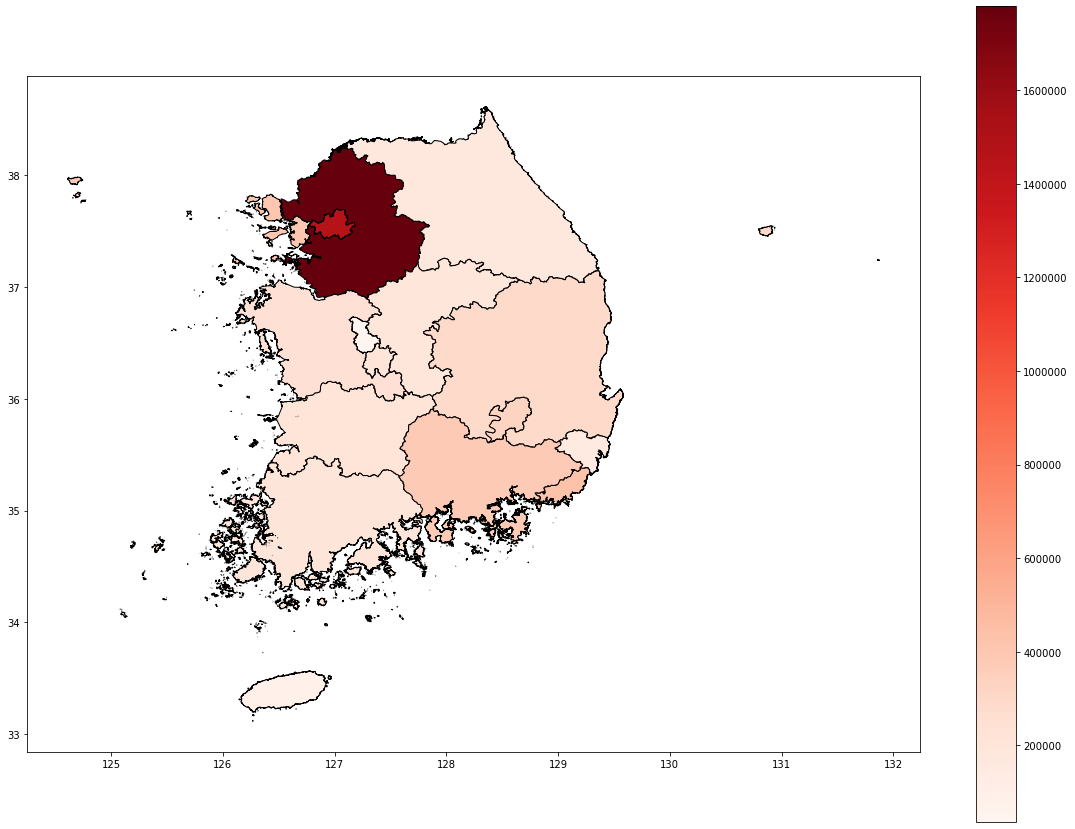

In [113]:
merge = pd.merge(korea, twtregion, how='left', on=['CTP_ENG_NM'])
merge.plot(column='20s',legend=True, cmap="Reds",edgecolor="black",figsize=(20,15))

In [114]:
fig = twtregion.iplot(asFigure=True,kind='bar', color = "#7201a8")
fig.show()

"전국 20대 분포 지도"와 "시도별 인구 현황 그래프"입니다.

**서울, 경기 지역에 20대가 제일 많아요.** 

아래에서 보듯이 확진자 수는 대구에 제일 많은데 말이에요.

In [115]:
TP = TimeProvince[TimeProvince.date=='2020-04-20'].drop(['released','deceased','time','date'],axis=1)
regionconf = TP.set_index('province')

fig = regionconf.iplot(asFigure=True,kind='bar',color="#0d0887")
fig.show()

그렇다면, 20대 확진자는 어느 지역에 가장 많을까요??

In [123]:
twtinfo = PatientInfo[PatientInfo.age == '20s']
twtinforeg = pd.DataFrame(twtinfo.groupby('province').count().patient_id)
twtinforeg["CTP_ENG_NM"] = list(twtinforeg.index) 

,patient_id,CTP_ENG_NM
province,,
Busan,47,Busan
Chungcheongbuk-do,7,Chungcheongbuk-do
Chungcheongnam-do,15,Chungcheongnam-do
Daegu,8,Daegu
Daejeon,12,Daejeon
Gangwon-do,6,Gangwon-do
Gwangju,8,Gwangju
Gyeonggi-do,141,Gyeonggi-do
Gyeongsangbuk-do,299,Gyeongsangbuk-do


C:\Users\JYW\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning:

invalid value encountered in less



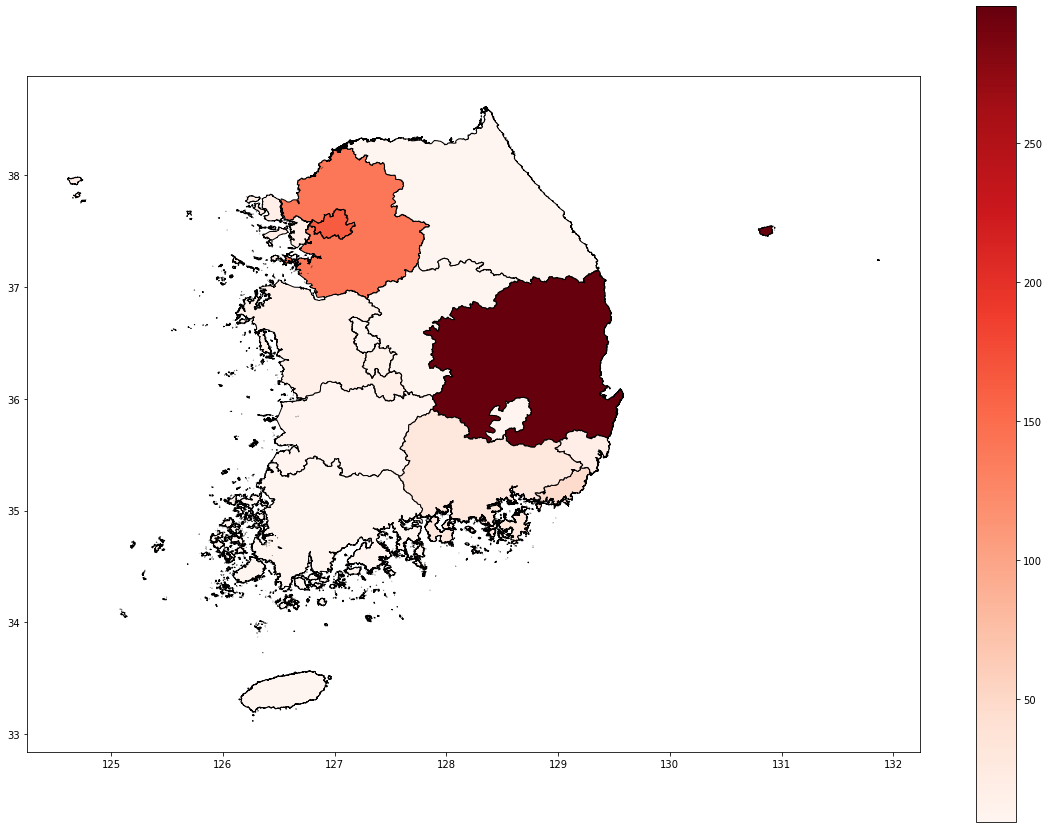

In [126]:
merge2 = pd.merge(korea, twtinforeg, how='left', on=['CTP_ENG_NM'])
merge2.plot(column='patient_id',legend=True, cmap="Reds",edgecolor="black",figsize=(20,15))

In [42]:
fig = twtinforeg.iplot(asFigure=True,kind='bar',color="#9c179e")
fig.show()

아니 이럴수가! 경상북도에 20대 확진자가 정말 많아요! 

그리고 그 다음으로 서울이랑 경기도에 많구요. 서울이랑 경기도에 20대 확진자가 많은 건 아무래도 그 두 지역에 20대가 많기 때문이겠죠.

도대체 **경상북도에 20대 코로나 환자가 왜 그렇게 많아진걸까요?!** 

우리는 이 미스테리를 풀어보고자 합니다... *To be continued*